In [ ]:
import pandas as pd
import numpy as np
import glob
import os
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GroupKFold, StratifiedKFold, train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [ ]:
! pip install fancyimpute

In [ ]:
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, BiScaler, IterativeImputer

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Retained features:
['HR' 'O2Sat' 'SBP' 'MAP' 'DBP' 'Resp' 'Hour' 'Age' 'Gender' 'HospAdmTime'
 'ICULOS' 'Identifier' 'SepsisLabel']
          HR      O2Sat         SBP        MAP        DBP       Resp  Hour    Age  Gender  HospAdmTime  ICULOS  Identifier  SepsisLabel
0   90.93789  93.657589  121.598611  76.976843  53.146823  20.640517   0.0  83.14     0.0        -0.03     1.0         1.0          0.0
1   97.00000  95.000000   98.000000  75.330000  54.792815  19.000000   1.0  83.14     0.0        -0.03     2.0         1.0          0.0
2   89.00000  99.000000  122.000000  86.000000  60.403662  22.000000   2.0  83.14     0.0        -0.03     3.0         1.0          0.0
3   90.00000  95.000000  120.708291  77.137986  53.598470  30.000000   3.0  83.14     0.0        -0.03     4.0         1.0          0.0
4  103.00000  88.500000  122.000000  91.330000  65.527235  24.500000   4.0  83.14     0.0        -0.03     5.0         1.0          0.0


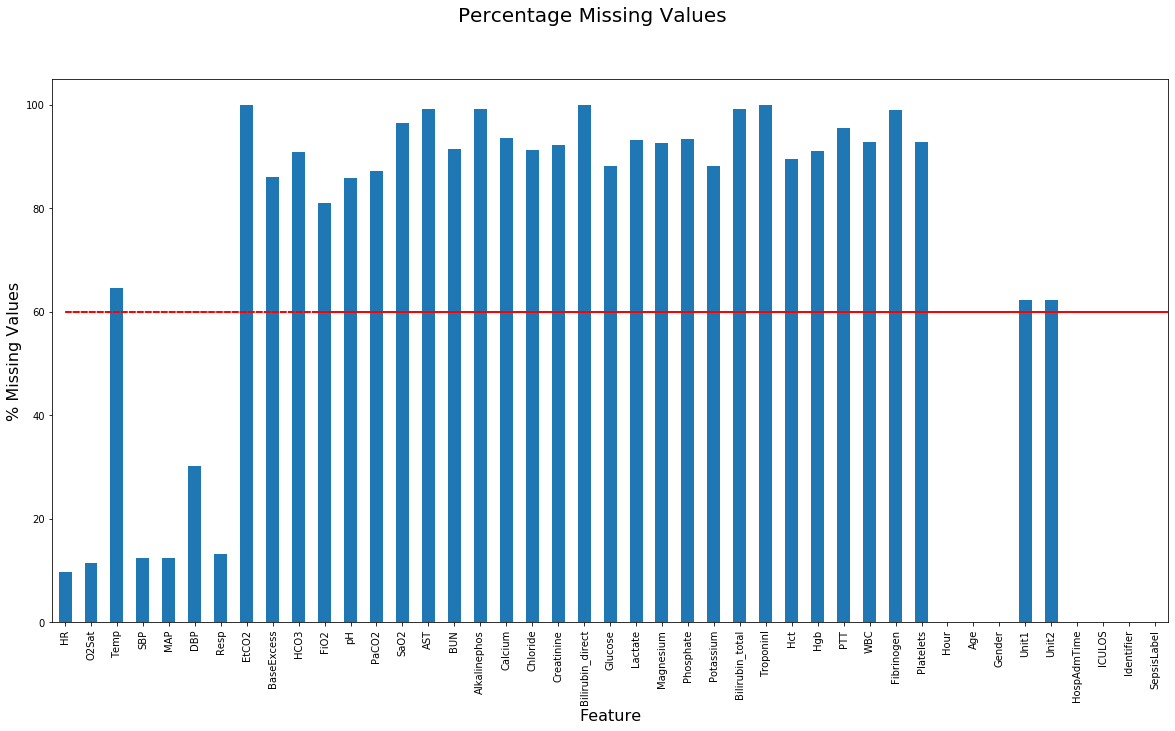

In [ ]:
# Read data and impute missing values
#os.chdir('/content/drive/My Drive/Colab Notebooks/PhysioNet_Sepsis_Challenge')
os.chdir('/content/drive/My Drive/Colab Notebooks/PhysionetSepsisChallenge')
df = pd.DataFrame()
for file in glob.iglob('Data/Data_partial/*.psv'):
    f_name = float(os.path.splitext(os.path.basename(file))[0][1:])  
    # print(f_name)  
    tempdf = pd.read_csv(file, sep = '|', index_col = None, header = 0)    
    tempdf['Hour'] = tempdf.index
    tempdf['Identifier'] = f_name
    df = pd.concat([df, tempdf], axis=0)

# Names of all columns in the data that contain physiological data
physiological_cols = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets']

# Names of all columns in the data that contain demographic data
demographic_cols = ['Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS']

# Columns of features
feature_cols = physiological_cols + ['Hour'] + demographic_cols + ['Identifier']

# The name of the column that contains the value we are trying to predict
label_col = 'SepsisLabel'

#cols = list(df)
cols = feature_cols + [label_col]
# Move the SepsisLabel column to end of dataframe
#cols.insert(len(cols), cols.pop(cols.index('SepsisLabel')))
df = df.loc[:, cols]

# Plot percentage of missing values (NaNs) for each feature
cutoff = 60
fig = plt.figure(figsize=(20,10))
percent_missing = (df.isna().sum()/df.shape[0])*100
percent_missing.plot(kind="bar")
plt.plot(percent_missing, np.array([cutoff for i in range(len(percent_missing))]), 'r--') 
fig.suptitle('Percentage Missing Values', fontsize=20)
plt.xlabel('Feature', fontsize=16)
plt.ylabel('% Missing Values', fontsize=16)

# Retain columns in dataframe with <= cutoff% missing values 
df = df.loc[:, df.columns[percent_missing <= cutoff]]
print('Retained features:')
print(df.columns.values)

feature_cols = df.columns.values[:-1]
# Adjust physiological and demographic column names
physiological_cols = [x for x in feature_cols if x in set(physiological_cols)]
demographic_cols = [x for x in feature_cols if x in set(demographic_cols)]

# Impute missing data using fancyimpute package 
df_filled = pd.DataFrame(data = IterativeImputer().fit_transform(df.to_numpy()),
                         columns = df.columns,
                         index = df.index)
pd.set_option('display.expand_frame_repr', False)
print(df_filled.head(5))

In [ ]:
# Names of all columns in the data that contain demographic data
demographic_cols = ['Age','Gender' ,'HospAdmTime', 'ICULOS', 'Identifier']
physiological_cols = ['HR' ,'O2Sat' ,'SBP', 'MAP', 'DBP' ,'Resp']
# The combination of physiological and demographic data is what we will use as features in our model
feature_cols = physiological_cols + demographic_cols

# The name of the column that contains the value we are trying to predict
label_col = "SepsisLabel"

def flatten(in_df, hours=4):
    res = []

    new_cols = []
    for i in range(hours):
        new_cols.append([c + "_" + str(i) for c in feature_cols])

    #print(new_cols) #list that has names of new columns

    df = in_df.sort_values("Hour")
   # print(df.iloc[-500:,:])
    for patient, _df in df.groupby("Identifier"):
        n = int(len(_df) / hours) #_df has the number of rows in each unique group of "Identifier"

        for i in range(n):
            window = _df.iloc[i*hours:(i+1)*hours]
            window_dict = {}

            for j in range(hours):
                for c in physiological_cols:
                    window_dict[c + "_" + str(j)] = window[c].iloc[j]

            for c in demographic_cols:
                window_dict[c] = window[c].iloc[0]

            window_dict[label_col] = window[label_col].mean()
            window_dict["patient"] = patient

            res.append(window_dict)

    res = pd.DataFrame(res)

    res = res[res[label_col] <= 1 / hours]
    res[label_col] = res[label_col].apply(lambda x: 1 if x else 0)

    return res
  
df_filled_flatten = flatten(df_filled)
df_filled_flatten[74:136] #printing the information of just patient 9 



,HR_0,O2Sat_0,SBP_0,MAP_0,DBP_0,Resp_0,HR_1,O2Sat_1,SBP_1,MAP_1,DBP_1,Resp_1,HR_2,O2Sat_2,SBP_2,MAP_2,DBP_2,Resp_2,HR_3,O2Sat_3,SBP_3,MAP_3,DBP_3,Resp_3,Age,Gender,HospAdmTime,ICULOS,Identifier,SepsisLabel,patient
74,96.537964,98.533285,114.147204,69.647189,55.645112,20.816360,117.000000,99.000000,116.000000,97.000000,81.000000,20.000000,96.793996,98.526412,114.230461,69.827433,55.800597,20.861704,96.922011,98.522975,114.272089,69.917555,55.87834,20.884377,27.92,1.0,-0.03,1.0,9.0,0,9.0
75,97.050027,98.519539,114.313717,70.007677,55.956082,20.907049,97.178043,98.516102,114.355346,70.097799,56.033825,20.929721,120.000000,100.000000,118.000000,84.000000,64.000000,30.000000,109.500000,98.500000,106.000000,74.000000,59.00000,27.000000,27.92,1.0,-0.03,5.0,9.0,0,9.0
76,102.500000,97.000000,98.500000,72.500000,58.500000,24.500000,98.000000,100.000000,93.000000,65.000000,51.000000,30.000000,110.500000,92.500000,83.500000,59.000000,46.000000,35.000000,99.000000,93.000000,78.000000,56.000000,45.00000,21.000000,27.92,1.0,-0.03,9.0,9.0,0,9.0
77,95.000000,90.500000,121.000000,80.000000,63.000000,17.000000,96.500000,89.500000,109.500000,80.500000,67.500000,16.000000,104.000000,91.000000,96.000000,66.000000,54.000000,16.000000,107.000000,94.000000,106.000000,72.500000,61.00000,35.000000,27.92,1.0,-0.03,13.0,9.0,0,9.0
78,102.000000,95.000000,111.000000,76.000000,65.000000,21.000000,99.000000,96.000000,106.000000,75.000000,64.000000,16.000000,99.500000,92.000000,122.500000,79.500000,65.500000,16.500000,98.000000,93.000000,115.500000,73.500000,60.00000,20.750000,27.92,1.0,-0.03,17.0,9.0,0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,135.000000,97.000000,130.000000,93.000000,73.000000,27.500000,131.000000,98.000000,105.000000,75.000000,59.000000,24.000000,129.000000,100.000000,133.500000,99.500000,80.000000,26.500000,128.000000,99.500000,137.500000,104.000000,84.00000,26.500000,27.92,1.0,-0.03,229.0,9.0,0,9.0
132,122.000000,99.000000,152.000000,113.000000,90.000000,28.500000,117.000000,96.000000,146.000000,112.000000,91.000000,27.000000,119.000000,97.000000,151.000000,117.000000,95.000000,32.000000,125.000000,95.000000,153.000000,115.000000,93.00000,30.000000,27.92,1.0,-0.03,233.0,9.0,0,9.0
133,128.000000,96.000000,149.000000,113.000000,92.000000,28.500000,129.000000,94.000000,136.000000,102.000000,83.000000,28.000000,133.000000,94.000000,141.000000,106.000000,86.000000,33.000000,137.000000,94.000000,142.000000,106.000000,87.00000,30.000000,27.92,1.0,-0.03,237.0,9.0,0,9.0
134,138.000000,96.000000,142.000000,108.000000,87.000000,30.500000,140.000000,96.000000,138.000000,102.000000,83.000000,32.000000,135.000000,97.000000,136.000000,101.000000,82.000000,31.000000,129.000000,98.000000,139.000000,105.000000,85.00000,29.000000,27.92,1.0,-0.03,241.0,9.0,0,9.0


In [ ]:
# Features and output labels
X = df_filled_flatten.drop(['Identifier', 'SepsisLabel', 'patient'], axis=1).values
y = df_filled_flatten['SepsisLabel'].values
#print(X.shape)
print(y.shape)
#X
y

(147,)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# Group k-fold cross-validation to ensure a 
# specific patient's data is either in the
# training or test set

group = df_filled_flatten['Identifier'].to_numpy()
train_pred = []
train_actual = []

test_pred = []
test_actual = []

kf = GroupKFold(n_splits=5)
for train_idx, test_idx in kf.split(X, y, group):
   X_train, y_train = X[train_idx, :], y[train_idx]
   X_test, y_test = X[test_idx, :], y[test_idx]
   
   # Decision tree classifier with higher penalty
   # for misclassifying the low frequency output
   # label
   clf = DecisionTreeClassifier(class_weight="balanced",
                                max_depth=20,
                                max_leaf_nodes=20)
   model = clf.fit(X_train, y_train)

   train_pred.extend(clf.predict(X_train))
   train_actual.extend(y_train)

   test_pred.extend(clf.predict(X_test))
   test_actual.extend(y_test)

In [ ]:
# Function for evaluating train and test accuracy
def evaluate(actual, predicted, prefix=""):
    precision = precision_score(actual, predicted)
    recall = recall_score(actual, predicted)
    accuracy = accuracy_score(actual, predicted)

    print("%s Precision: %.3f%%, Recall: %.3f%%, Accuracy: %.3f%%" % (prefix, precision * 100, recall * 100, accuracy * 100))

In [ ]:
# Evaluate train and test accuracy
evaluate(train_actual, train_pred, "Train")
evaluate(test_actual, test_pred, "Test")

Train Precision: 0.000%, Recall: 0.000%, Accuracy: 100.000%
Test Precision: 0.000%, Recall: 0.000%, Accuracy: 100.000%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
